In [1]:
import pandas as pd
import os
%load_ext zipline
from zipline.api import symbol, set_benchmark, order,record, order_target, get_open_orders,order_target_percent,set_benchmark
from zipline.utils.calendar_utils import get_calendar
from zipline import run_algorithm
import matplotlib.pyplot as plt
import numpy as np
from zipline.data import bundles
%matplotlib inline
import matplotlib.pyplot as plt
import quantstats as qs
from pyfolio.utils import extract_rets_pos_txn_from_zipline
from pyfolio.tears import create_full_tear_sheet

In [2]:
!zipline bundles;

csvdir <no ingestions>
quandl 2023-11-29 14:09:18.799451
quandl 2023-11-29 14:07:32.423012
quandl 2023-11-29 12:39:15.374615
quandl 2023-11-29 12:05:56.774662
quandl 2023-11-29 10:27:35.030664
quantopian-quandl 2023-11-30 02:02:00.355768
quantopian-quandl 2023-11-30 01:12:56.278980
quantopian-quandl 2023-11-30 01:11:49.450274
quantopian-quandl 2023-11-29 14:06:08.862893
quantopian-quandl 2023-11-29 13:55:59.391084
quantopian-quandl 2023-11-29 12:17:04.159981
quantopian-quandl 2023-11-29 10:27:07.529834
quantopian-quandl 2023-11-29 10:14:48.887188
sp5 2023-12-30 13:26:42.327070


In [3]:
# input_path = '/home/yakub/Documents/Finance_Data/Data/S_P 500 returns/OHLCV'
# output_path = '/home/yakub/Documents/Python/preprocessed_zipline_data/snp500/daily'
# file_list = []

# for file in os.listdir(input_path):
#     file_path = os.path.join(input_path, file)
#     data = pd.read_csv(file_path)
#     data = data.rename(columns={'date': 'timestamp'})
#     data.columns = data.columns.str.lower()
#     data['timestamp'] = pd.to_datetime(data['timestamp'])
#     data = data.set_index('timestamp')
#     data.to_csv(os.path.join(output_path, file),index=True,index_label='timestamp')

In [4]:
dt = pd.read_csv('/home/yakub/Documents/Python/preprocessed_zipline_data/snp500/daily/A.csv')

In [5]:
if dt.index.name == 'timestamp':
    print('yes')
else:
    print('no')

no


## EMA

$$ EMA = multiplier*{(P_t - EMA_{t-1})} + EMA_{t-1} $$
$$ multiplier = \frac{2}{n+1} $$
$$ n = \text{number of days} $$
$$ P_t = \text{price at time t} $$
$$ ema = \text{exponential moving average} $$

In [6]:
def ema(day,price_hist):
    mulitplier = 2/(day+1)
    ema_list = []
    ema_prev = price_hist[0]
    ema_list.append(ema_prev)
    
    for price in price_hist[1:]:
        ema = (price - ema_prev) * mulitplier + ema_prev
        ema_list.append(ema)
        ema_prev =ema
    
    return ema_list

## MACD

$$ MACD = EMA_{12} - EMA_{26} $$
$$ EMA_{12} = \text{12 day exponential moving average} $$
$$ EMA_{26} = \text{26 day exponential moving average} $$
$$ MACD_{signal} = EMA_{9} $$
$$ EMA_{9} = \text{9 day exponential moving average} $$
$$ MACD_{histogram} = MACD - MACD_{signal} $$

In [7]:
# calendar = get_calendar('XNYS')
# capital_base = 10000

# def initialize(context):
#     context.i = 0
#     context.asset = symbol("AAPL")
    
# def handle_data(context, data):
#     context.i += 1
#     if context.i < 1: return
    
#     buy_signal = False
#     sell_signal  =False
#     price_hist = data.history(context.asset,'price', bar_count=26, frequency='1d')
    
#     ema_26 = ema(26,price_hist)
#     ema_12 = ema(12,price_hist)
#     MACD = [ema_26[j]-ema_12[j] for j in range(len(price_hist))]
#     signal = ema(9,MACD)
    
#     open_orders = get_open_orders()
#     if context.asset not in open_orders:
#         if MACD[-1]>signal[-1] and MACD[-2] < signal[-2]:    # Bullish crossover
#             order(context.asset,1)
#             buy_signal = True
#         elif MACD[-1]<signal[-1] and MACD[-2] > signal[-2]:    # Bearish crossover
#             order(context.asset,0)
#             sell_signal = True
    
#     record( amz_close = data.current(context.asset, "close"),
#             MACD = MACD[-1],
#             signal =signal[-1],
#             sell_signal = sell_signal,
#             buy_signal = buy_signal,
#             price_hist = price_hist
#             )

### Take 5 assets from the snp500

In [74]:
%%capture
calendar = get_calendar('XNYS')
capital_base = 10000

def initialize(context):
    context.i = 0
    set_benchmark(symbol('ABC'))
    context.assets = [symbol("AMZN"), symbol("AAPL"), symbol("GOOGL"),symbol("TSLA"),symbol("MSFT")]
    
def handle_data(context, data):
    context.i += 1
    if context.i < 1: return
    for asset in context.assets:
        buy_signal = False
        sell_signal  =False
        price_hist = data.history(asset,'price', bar_count=26, frequency='1d')
        long_term_mavg = data.history(asset, 'close', bar_count=100, frequency='1d').mean()
        trend_up = price_hist[-1] > long_term_mavg
        
        ema_26 = ema(26,price_hist)
        ema_12 = ema(12,price_hist)
        MACD = [ema_26[j]-ema_12[j] for j in range(len(price_hist))]
        signal = ema(9,MACD)
        
        open_orders = get_open_orders()
        if asset not in open_orders:
            if MACD[-1]>signal[-1] and MACD[-2] < signal[-2] and trend_up:    # Bullish crossover
                order_target_percent(asset,0.5)
                buy_signal = True
            elif MACD[-1]<signal[-1] and MACD[-2] > signal[-2]:    # Bearish crossover
                order_target_percent(asset,-0.5)
                sell_signal = True
            # else:
            #     order_target_percent(asset, 0)
        
        record( closing_price = data.current(asset, "close"),
                MACD = MACD[-1],
                signal =signal[-1],
                sell_signal = sell_signal,
                buy_signal = buy_signal,
                long_term_mavg=long_term_mavg,
                price_hist = price_hist
                )
        


start_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2021-01-01', format='%Y-%m-%d')

result = run_algorithm(
    start = start_date,
    end = end_date,
    initialize=initialize,
    handle_data = handle_data,
    trading_calendar=calendar,
    bundle='sp5',
    capital_base=capital_base,
    data_frequency='daily'
)

#stop_loss

In [9]:
# calendar = get_calendar('XNYS')
# capital_base = 10000

# def initialize(context):
#     context.i = 0
#     context.assets = [symbol("AMZN"), symbol("AAPL"), symbol("GOOGL"),symbol("TSLA"),symbol("MSFT")]
    
# def handle_data(context, data):
#     context.i += 1
#     if context.i < 1: return
#     for asset in context.assets:
#         buy_signal = False
#         sell_signal  =False
#         price_hist = data.history(asset,'price', bar_count=26, frequency='1d')
#         long_term_mavg = data.history(asset, 'close', bar_count=200, frequency='1d').mean()
#         trend_up = price_hist[-1] > long_term_mavg
        
#         ema_26 = ema(26,price_hist)
#         ema_12 = ema(12,price_hist)
#         MACD = [ema_26[j]-ema_12[j] for j in range(len(price_hist))]
#         signal = ema(9,MACD)
#         stop_loss_percentage = 2.0  # Adjust as needed
#         current_price = data.current(asset, 'close')
#         stop_loss_price = current_price * (1 - stop_loss_percentage / 100.0)
        
#         open_orders = get_open_orders()
#         if asset not in open_orders:
#             if MACD[-1]>signal[-1] and MACD[-2] < signal[-2] and trend_up:    # Bullish crossover
#                 order_target_percent(asset,0.5)
#                 buy_signal = True
#             elif MACD[-1]<signal[-1] and MACD[-2] > signal[-2] and current_price < stop_loss_price:    # Bearish crossover
#                 order_target_percent(asset,-0.5)
#                 sell_signal = True
        
#         record( closing_price = data.current(asset, "close"),
#                 MACD = MACD[-1],
#                 signal =signal[-1],
#                 sell_signal = sell_signal,
#                 buy_signal = buy_signal,
#                 price_hist = price_hist,
#                 stop_loss_price=stop_loss_price
#                 )

In [75]:
result.tail(5)

,period_open,period_close,gross_leverage,short_value,pnl,long_value,shorts_count,longs_count,ending_cash,starting_value,...,beta,max_drawdown,algorithm_period_return,period_label,algo_volatility,max_leverage,trading_days,benchmark_period_return,benchmark_volatility,treasury_period_return
2020-12-24 18:00:00+00:00,2020-12-24 14:31:00+00:00,2020-12-24 18:00:00+00:00,2.668852,-5215.930,21.091000,3278.290,3,2,5120.364390,-1958.731,...,0.763237,-0.862579,-0.681728,2020-12,1.279885,9.591916,249,0.140555,0.418977,0.0
2020-12-28 21:00:00+00:00,2020-12-28 14:31:00+00:00,2020-12-28 21:00:00+00:00,2.810549,-5355.320,-95.110000,3322.570,3,2,5120.364390,-1937.640,...,0.763638,-0.862579,-0.691239,2020-12,1.277633,9.591916,250,0.138556,0.418144,0.0
2020-12-29 21:00:00+00:00,2020-12-29 14:31:00+00:00,2020-12-29 21:00:00+00:00,2.800936,-5342.380,2.109000,3311.739,3,2,5120.364390,-2032.750,...,0.763642,-0.862579,-0.691028,2020-12,1.275077,9.591916,251,0.142319,0.417314,0.0
2020-12-30 21:00:00+00:00,2020-12-30 14:31:00+00:00,2020-12-30 21:00:00+00:00,2.710874,-5288.440,99.592000,3357.391,3,2,5120.364390,-2030.641,...,0.763125,-0.862579,-0.681068,2020-12,1.272981,9.591916,252,0.140438,0.416489,0.0
2020-12-31 21:00:00+00:00,2020-12-31 14:31:00+00:00,2020-12-31 21:00:00+00:00,2.591651,-6676.818,63.228051,1752.640,4,1,8176.721441,-1931.049,...,0.763785,-0.862579,-0.674746,2020-12,1.270627,9.591916,253,0.149847,0.415727,0.0


## Funtions for Plotting

In [76]:
def plot_macd(result, buy_signal=None, sell_signal=None):
    fig2, ax2 = plt.subplots(3, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [2, 4, 2]})


    # Closing price, signals, and long MA
    result["closing_price"].plot(ax=ax2[0], color='green', title="Closing Price")
    result["long_term_mavg"].plot(ax=ax2[0], color='purple', label="100-period MA")  # Added long MA
    result.loc[result["buy_signal"], "closing_price"].plot(ax=ax2[0], color='black', ls='None', marker='v', label="Long (buy)")
    result.loc[result["sell_signal"], "closing_price"].plot(ax=ax2[0], color='red', ls='None', marker='^', label="Sell (short)")
    ax2[0].legend()
    print(f'Buy signals: {result["buy_signal"].sum()}')
    print(f'Sell signals: {result["sell_signal"].sum()}')
    # MACD and signal line
    result["MACD"].plot(ax=ax2[1], color='blue', label="MACD")
    result["signal"].plot(ax=ax2[1], color='orange', label="Signal")
    ax2[1].legend()

    # Portfolio value
    result["portfolio_value"].plot(ax=ax2[2], color="blue", label="Portfolio Value")
    ax2[2].legend()
    plt.show()


Buy signals: 10
Sell signals: 9


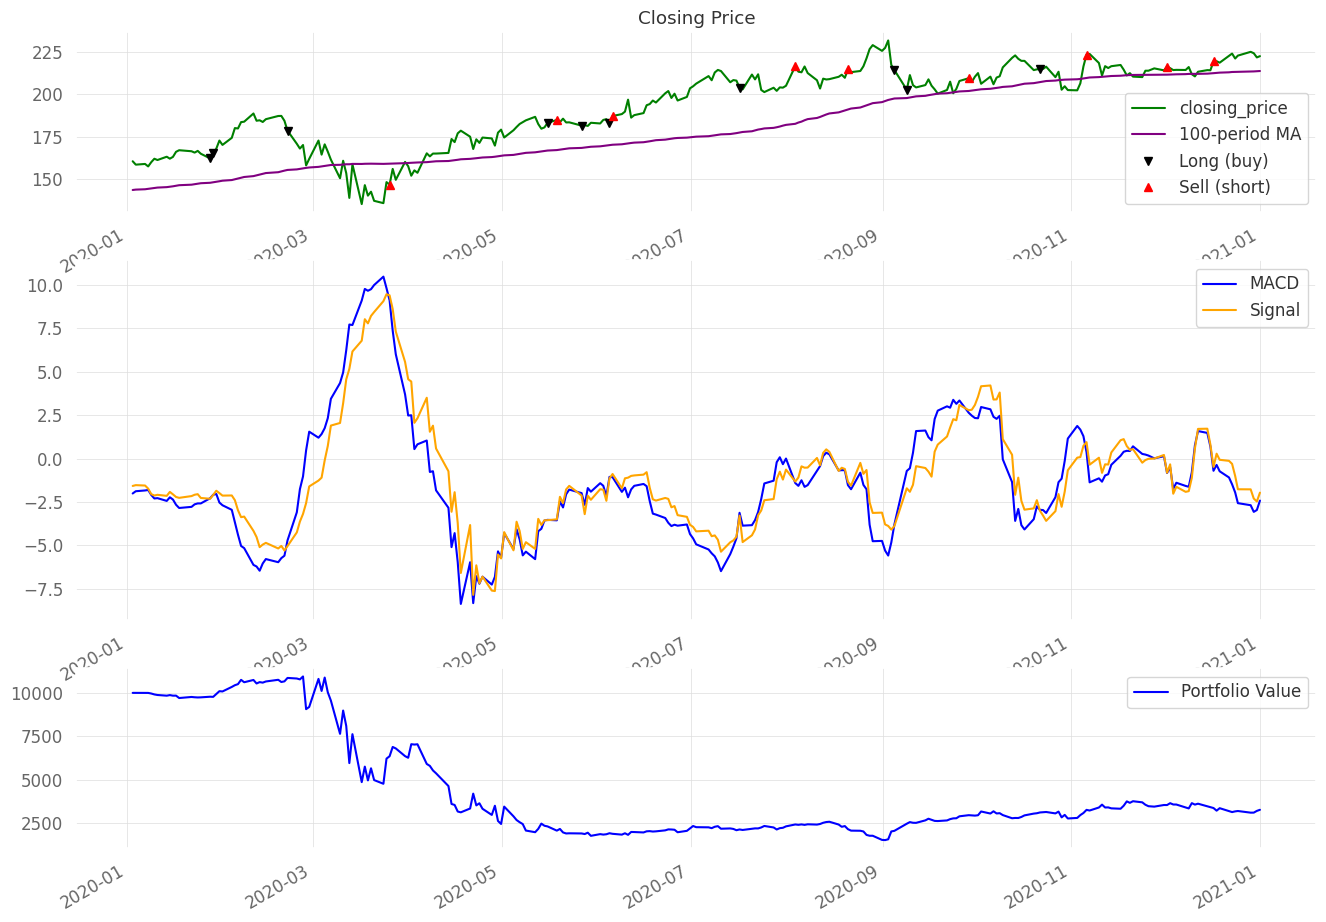

In [77]:
plot_macd(result)

## Check the performace of the strategy with a benchmark 'SPY'

Read the data of SnP500

In [78]:
spy = pd.read_csv("custom_data/d1/spy.csv")
spy.timestamp = pd.to_datetime(spy.timestamp)
spy.set_index('timestamp',inplace=True)
spy_return_series = spy['close'].pct_change()

In [79]:
spy_return_series = spy_return_series['2020-01-01':'2021-01-01']
spy_return_series


timestamp
2020-01-02    0.009352
2020-01-03   -0.007572
2020-01-06    0.003815
2020-01-07   -0.002812
2020-01-08    0.005330
                ...   
2020-12-24    0.003890
2020-12-28    0.008591
2020-12-29   -0.001908
2020-12-30    0.001427
2020-12-31    0.005081
Name: close, Length: 253, dtype: float64

In [46]:
# spy_return_series.index = spy_return_series.index.tz_localize(None)

In [80]:
returns = result.returns
returns

2020-01-02 21:00:00+00:00    0.000000
2020-01-03 21:00:00+00:00    0.000000
2020-01-06 21:00:00+00:00    0.000000
2020-01-07 21:00:00+00:00   -0.000255
2020-01-08 21:00:00+00:00   -0.003522
                               ...   
2020-12-24 18:00:00+00:00    0.006671
2020-12-28 21:00:00+00:00   -0.029883
2020-12-29 21:00:00+00:00    0.000683
2020-12-30 21:00:00+00:00    0.032233
2020-12-31 21:00:00+00:00    0.019825
Name: returns, Length: 253, dtype: float64

In [83]:
returns.index = returns.index.tz_localize(None)
returns

2020-01-02 21:00:00    0.000000
2020-01-03 21:00:00    0.000000
2020-01-06 21:00:00    0.000000
2020-01-07 21:00:00   -0.000255
2020-01-08 21:00:00   -0.003522
                         ...   
2020-12-24 18:00:00    0.006671
2020-12-28 21:00:00   -0.029883
2020-12-29 21:00:00    0.000683
2020-12-30 21:00:00    0.032233
2020-12-31 21:00:00    0.019825
Name: returns, Length: 253, dtype: float64

In [52]:
# spy_return_series.index = spy_return_series.index.tz_localize('UTC')
# spy_return_series = spy_return_series.tz_convert('UTC')

In [84]:
print(returns.index.tz)
print(spy_return_series.index.tz)

None
None


/home/yakub/anaconda3/envs/ml/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axi

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-01-07   2020-01-07
End Period                 2020-12-31   2020-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             33.0%        100.0%

Cumulative Return          15.85%       -67.47%
CAGR﹪                     10.88%       -54.54%

Sharpe                     0.68         -0.25
Prob. Sharpe Ratio         79.33%       40.39%
Smart Sharpe               0.52         -0.19
Sortino                    1.54         -0.36
Smart Sortino              1.18         -0.27
Sortino/√2                 1.09         -0.25
Smart Sortino/√2           0.83         -0.19
Omega                      0.95         0.95

Max Drawdown               -18.95%      -86.26%
Longest DD Days            258          309
Volatility (ann.)          26.82%       127.83%
R^2                        0.0          0.0
Information Ratio          -0.02        -0.02
Calmar    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-27,2020-09-01,2020-12-31,309,-86.257930,-84.004436
2,2020-01-08,2020-01-17,2020-01-29,22,-2.951478,-2.618213
3,2020-02-07,2020-02-11,2020-02-14,8,-1.946928,-1.493976
4,2020-02-19,2020-02-19,2020-02-20,2,-1.190284,-0.836735
5,2020-02-24,2020-02-25,2020-02-25,2,-0.782968,-0.311550


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


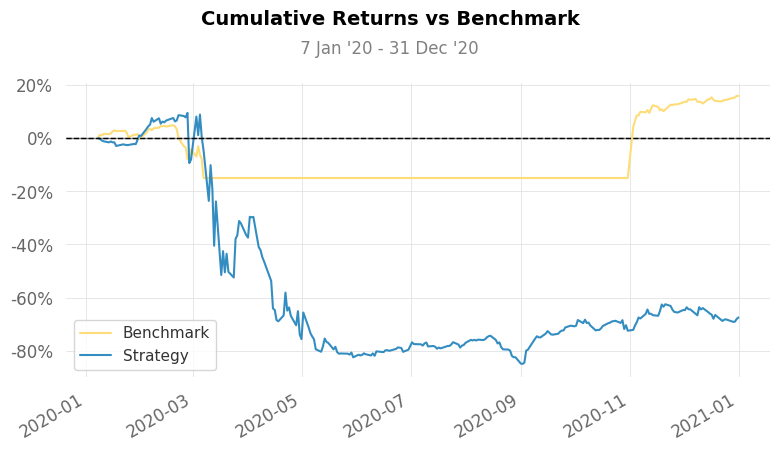

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


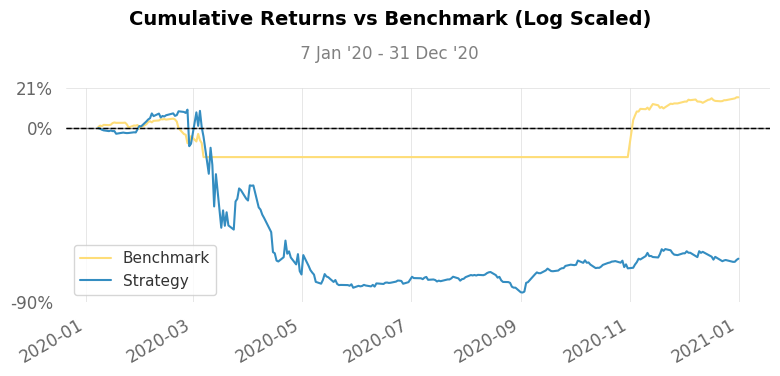

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


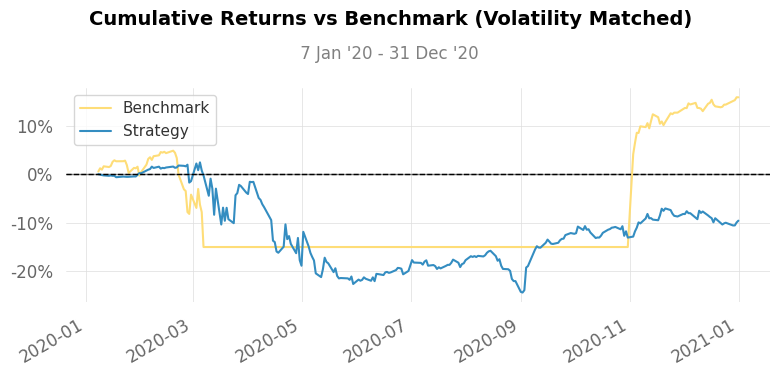

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


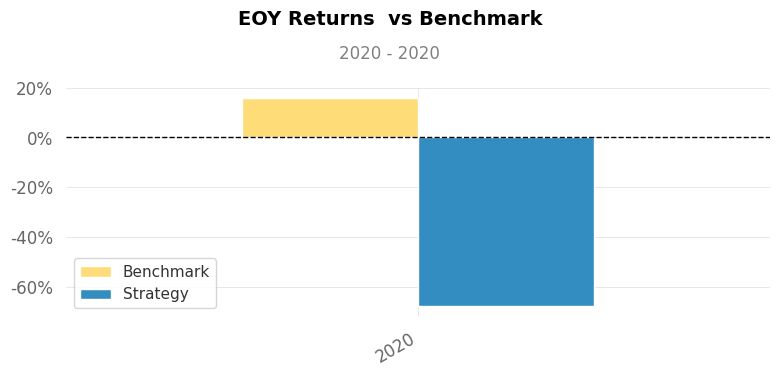

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


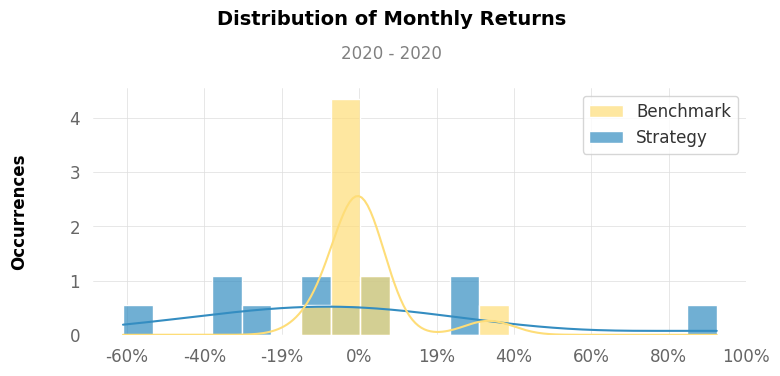

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


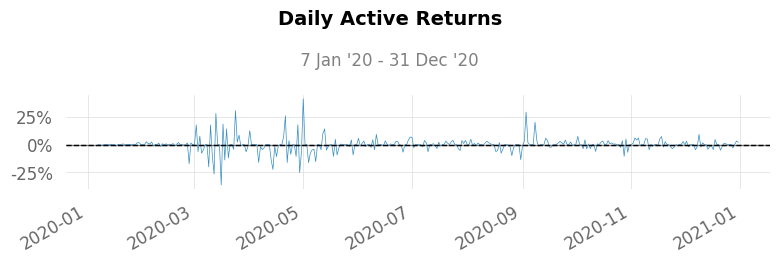

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


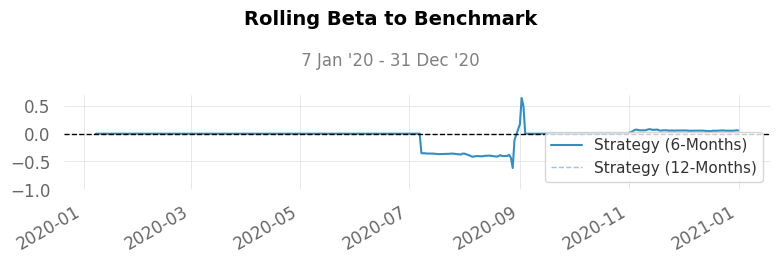

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


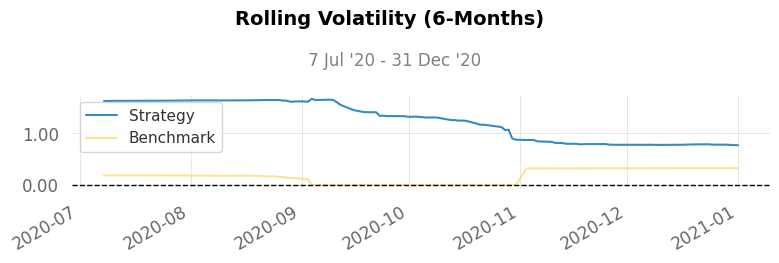

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


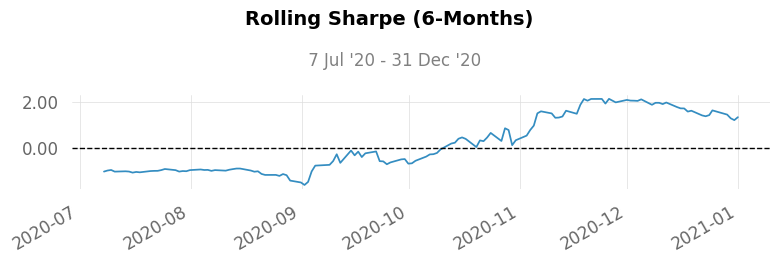

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


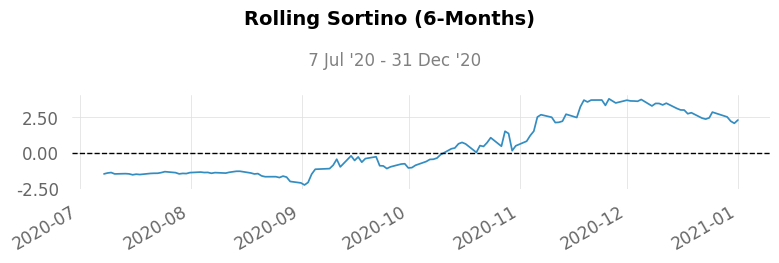

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


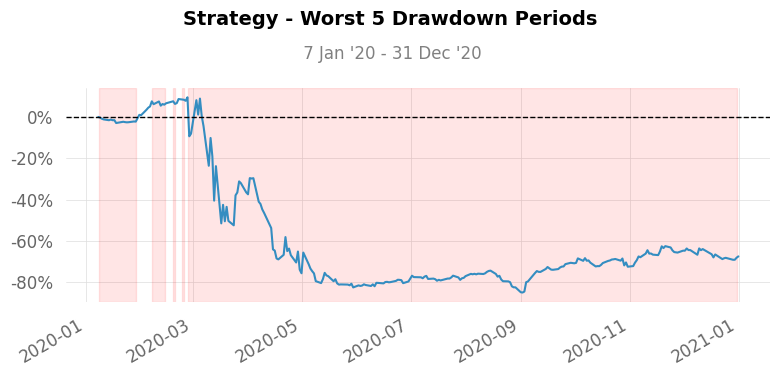

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


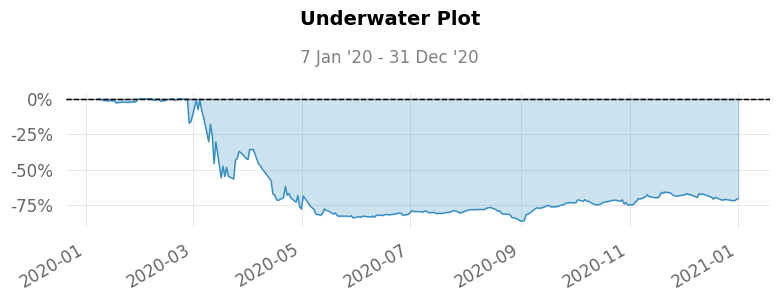

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


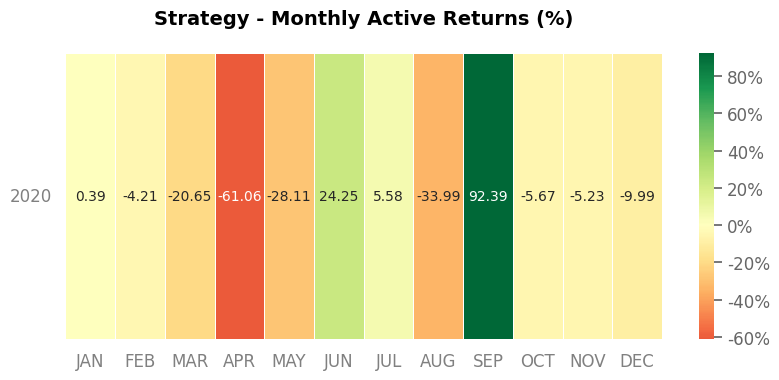

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


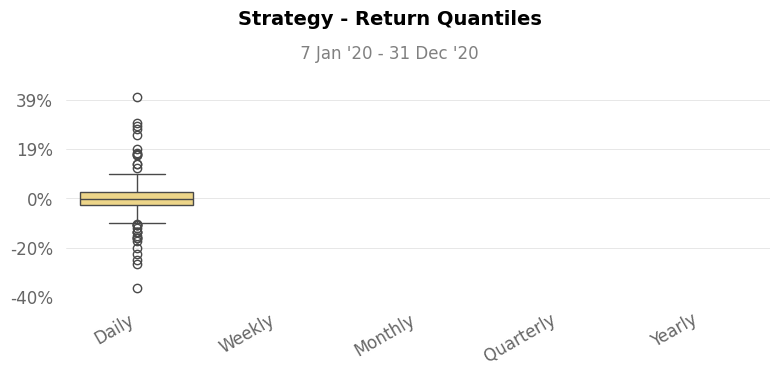

In [85]:
qs.reports.full(returns,benchmark=spy_return_series)

/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axi

                           Strategy
-------------------------  ----------
Start Period               2019-01-02
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          -38.23%
CAGR﹪                     -28.43%

Sharpe                     -1.03
Prob. Sharpe Ratio         15.28%
Smart Sharpe               -1.02
Sortino                    -1.44
Smart Sortino              -1.42
Sortino/√2                 -1.02
Smart Sortino/√2           -1.0
Omega                      0.83

Max Drawdown               -45.8%
Longest DD Days            336
Volatility (ann.)          39.18%
Calmar                     -0.62
Skew                       0.19
Kurtosis                   2.03

Expected Daily %           -0.19%
Expected Monthly %         -3.94%
Expected Yearly %          -38.23%
Kelly Criterion            -9.01%
Risk of Ruin               0.0%
Daily Value-at-Risk        -4.22%
Expected Shortfall (cVaR)  -4.22%

Max Consecutiv

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-01-30,2019-11-19,2019-12-31,336,-45.798009,-43.454918
2,2019-01-15,2019-01-17,2019-01-18,4,-8.170424,-6.972205
3,2019-01-03,2019-01-10,2019-01-11,9,-4.347751,-3.692068
4,2019-01-24,2019-01-25,2019-01-28,5,-4.122481,-1.657216


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


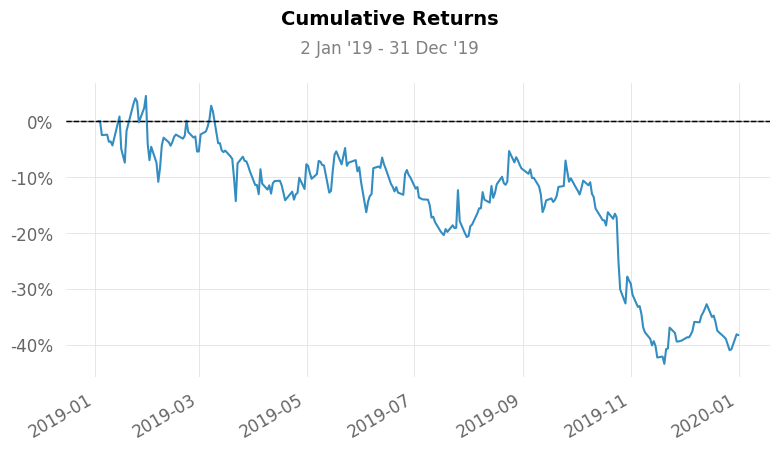

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


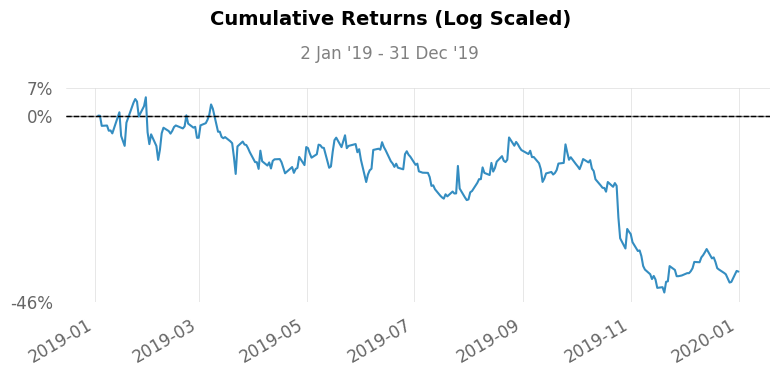

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


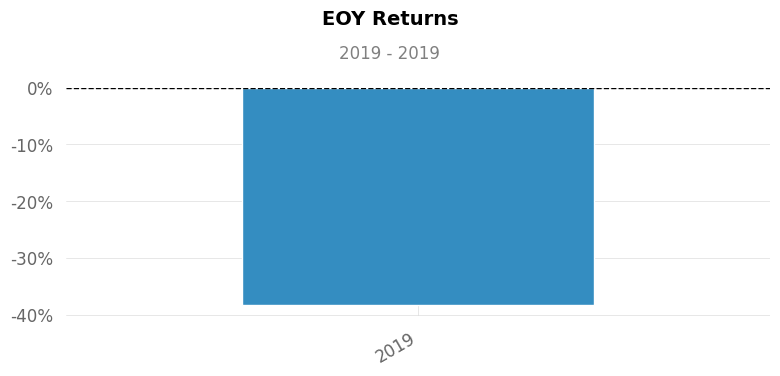

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


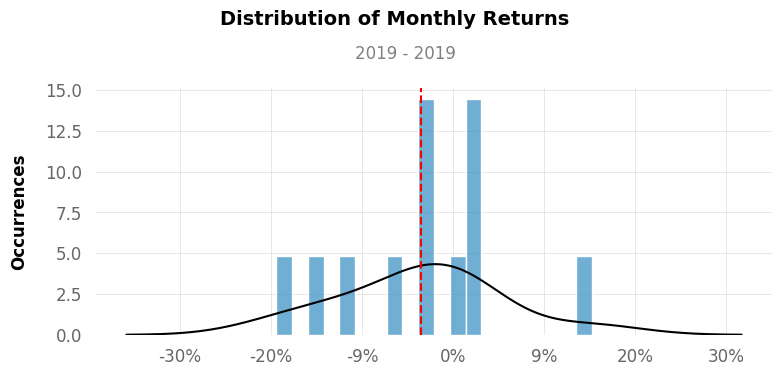

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


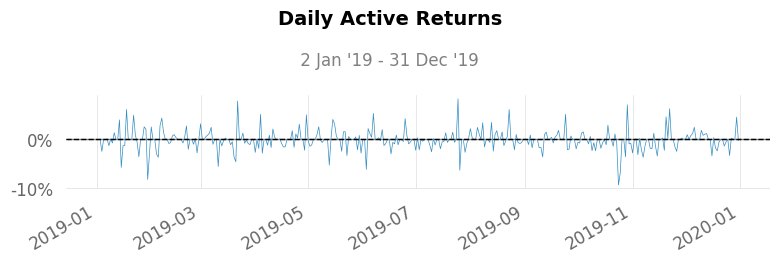

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


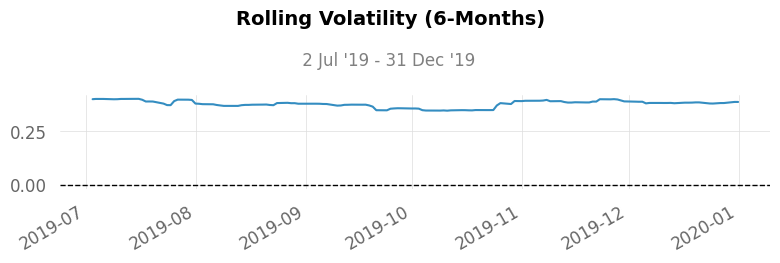

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


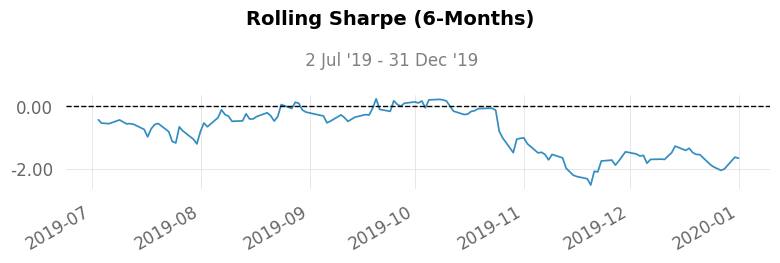

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


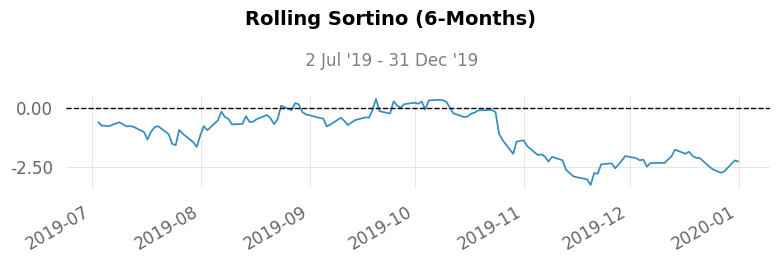

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


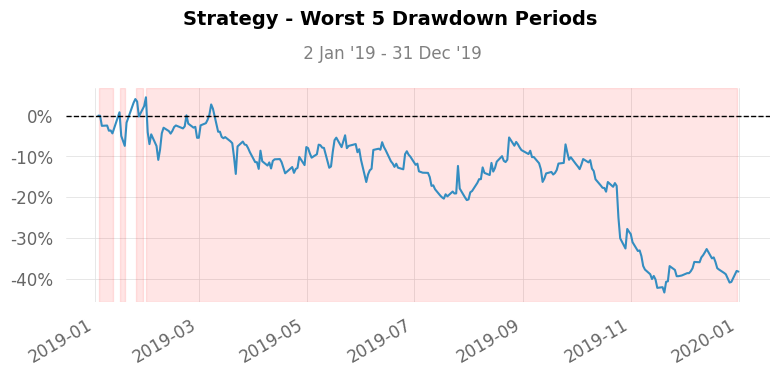

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


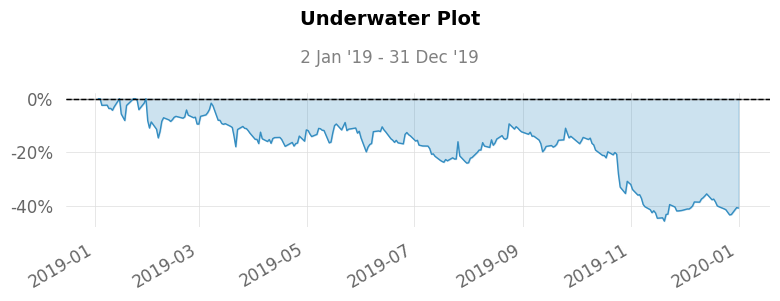

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


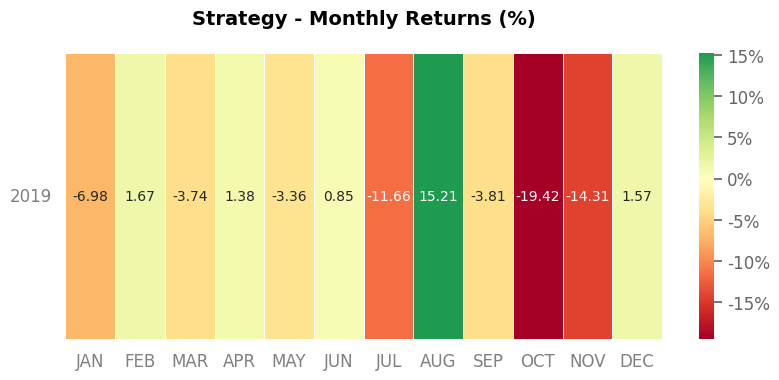

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


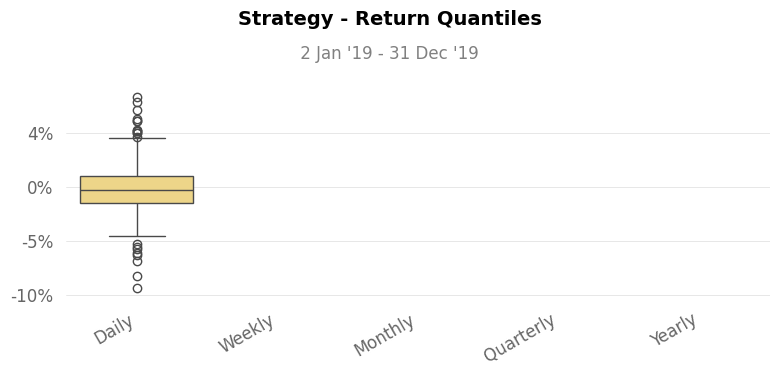

In [28]:
qs.reports.full(returns,benchmark_rets=spy_return_series)

Strategy tearsheet

/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axi

                           Strategy
-------------------------  ----------
Start Period               2019-01-02
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          -38.23%
CAGR﹪                     -28.43%

Sharpe                     -1.03
Prob. Sharpe Ratio         15.28%
Smart Sharpe               -1.02
Sortino                    -1.44
Smart Sortino              -1.42
Sortino/√2                 -1.02
Smart Sortino/√2           -1.0
Omega                      0.83

Max Drawdown               -45.8%
Longest DD Days            336
Volatility (ann.)          39.18%
Calmar                     -0.62
Skew                       0.19
Kurtosis                   2.03

Expected Daily %           -0.19%
Expected Monthly %         -3.94%
Expected Yearly %          -38.23%
Kelly Criterion            -9.01%
Risk of Ruin               0.0%
Daily Value-at-Risk        -4.22%
Expected Shortfall (cVaR)  -4.22%

Max Consecutiv

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-01-30,2019-11-19,2019-12-31,336,-45.798009,-43.454918
2,2019-01-15,2019-01-17,2019-01-18,4,-8.170424,-6.972205
3,2019-01-03,2019-01-10,2019-01-11,9,-4.347751,-3.692068
4,2019-01-24,2019-01-25,2019-01-28,5,-4.122481,-1.657216


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


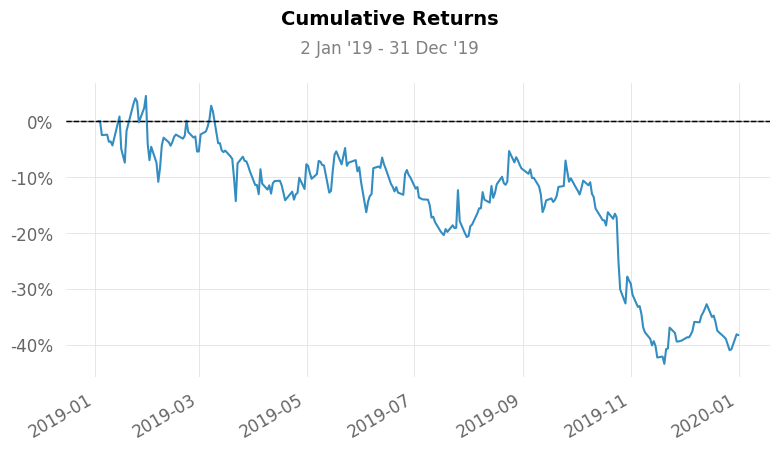

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


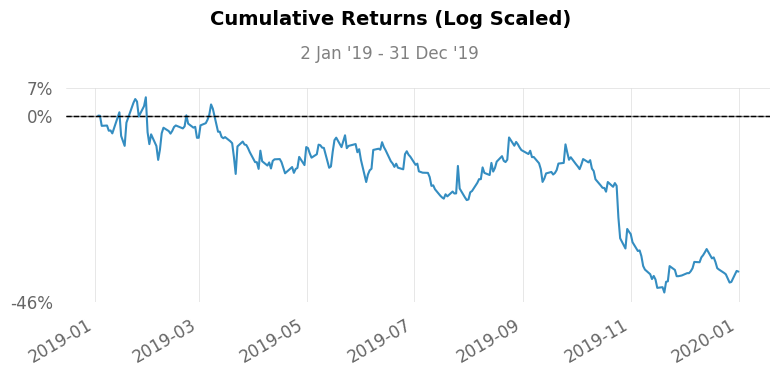

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


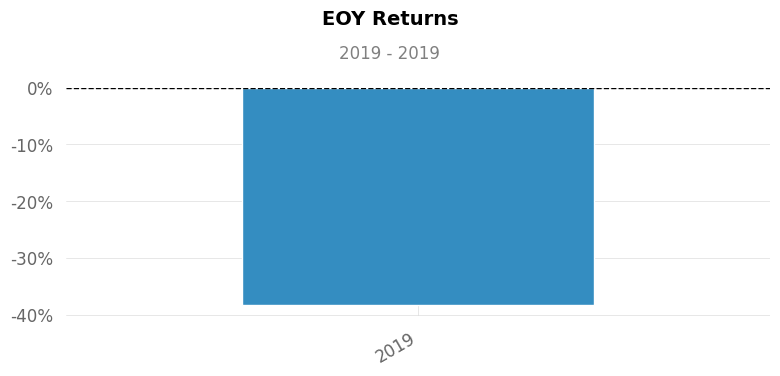

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


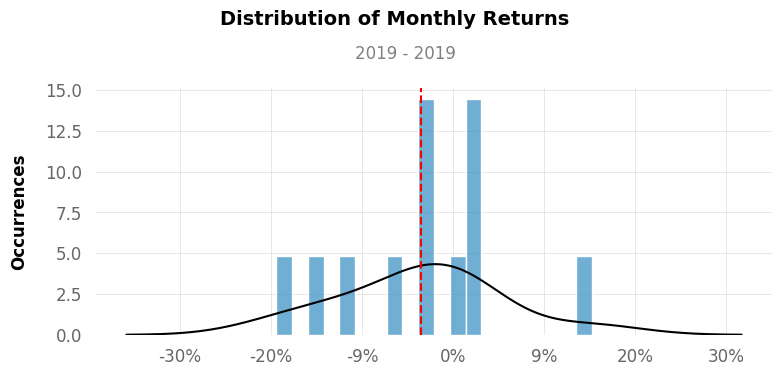

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


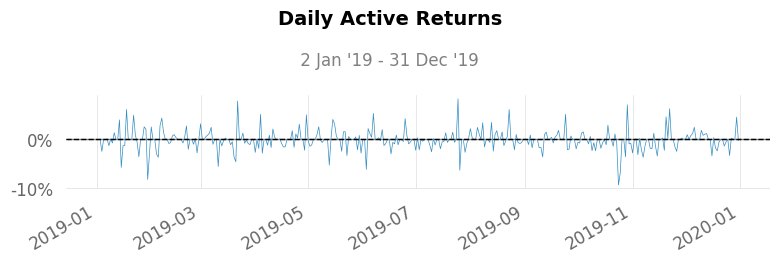

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


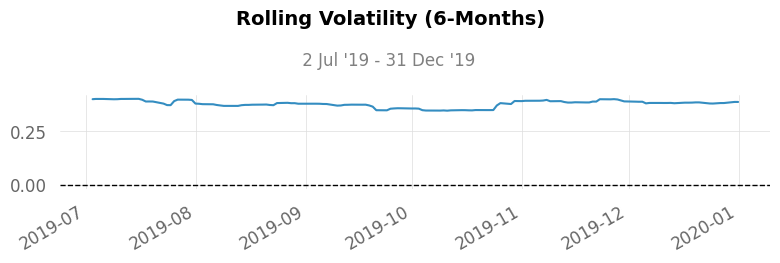

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


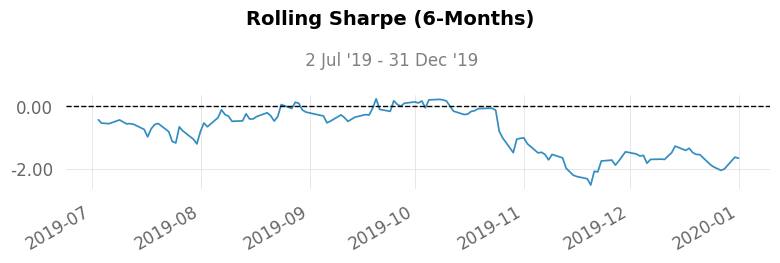

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


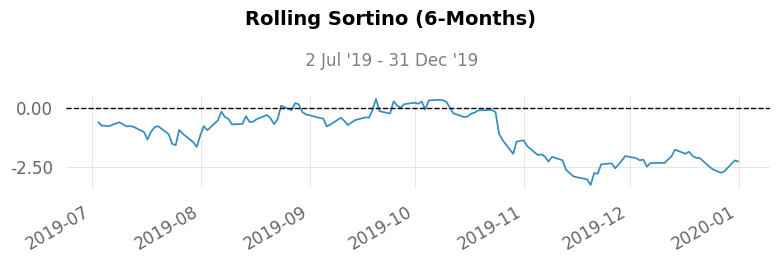

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


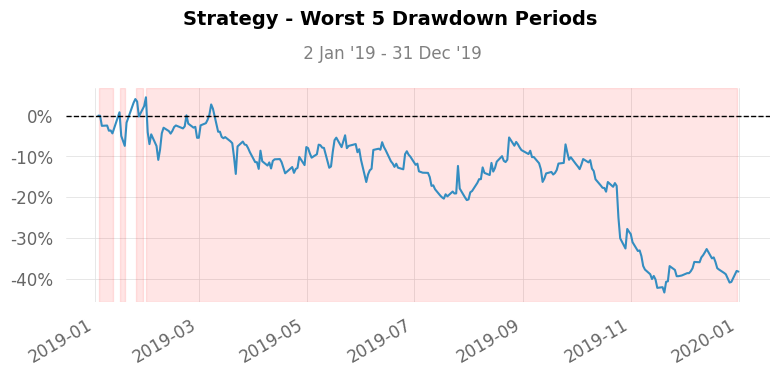

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


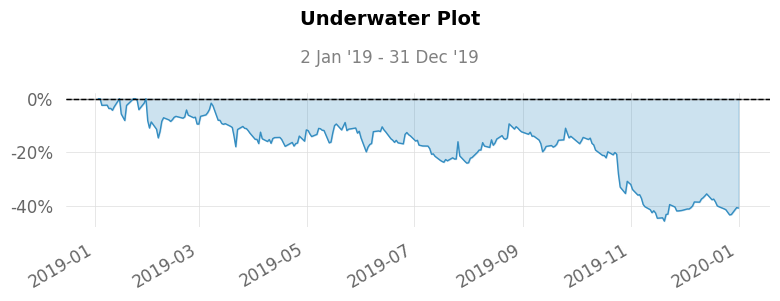

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


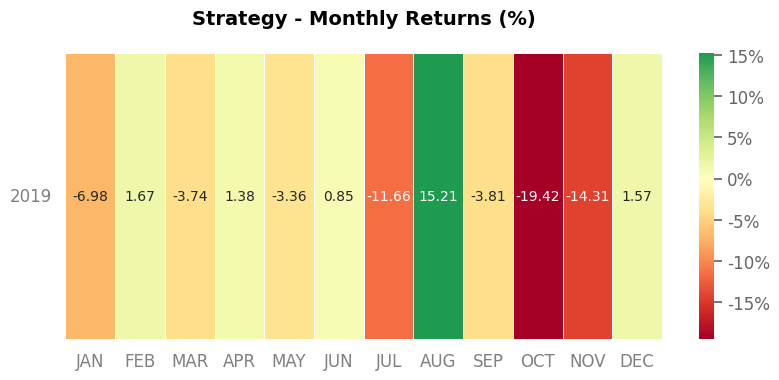

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


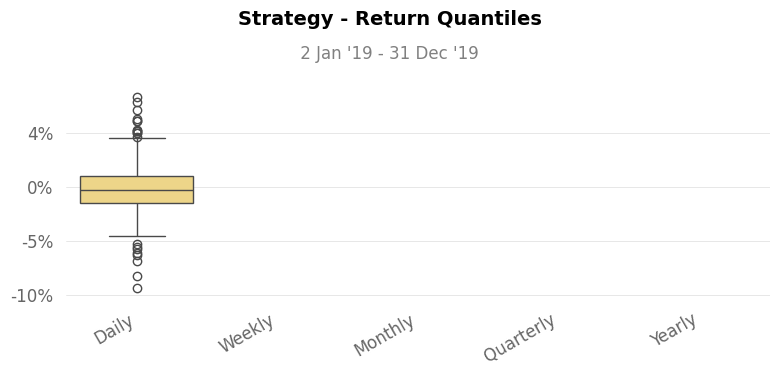

In [24]:
qs.reports.full(returns)

Benchmark

/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axi

                           Strategy
-------------------------  ----------
Start Period               2010-01-05
End Period                 2021-07-30
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          286.93%
CAGR﹪                     8.41%

Sharpe                     0.77
Prob. Sharpe Ratio         99.49%
Smart Sharpe               0.67
Sortino                    1.07
Smart Sortino              0.93
Sortino/√2                 0.76
Smart Sortino/√2           0.66
Omega                      1.16

Max Drawdown               -34.1%
Longest DD Days            417
Volatility (ann.)          17.14%
Calmar                     0.25
Skew                       -0.61
Kurtosis                   13.2

Expected Daily %           0.05%
Expected Monthly %         0.98%
Expected Yearly %          11.94%
Kelly Criterion            7.71%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.72%
Expected Shortfall (cVaR)  -1.72%

Max Consecutive Wins     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-20,2020-03-23,2020-08-17,180,-34.104747,-29.109769
2,2018-09-21,2018-12-24,2019-04-26,218,-20.178484,-16.816535
3,2011-05-02,2011-10-03,2012-02-17,292,-19.423876,-17.657405
4,2010-04-26,2010-07-02,2010-11-03,192,-16.098843,-15.548802
5,2015-05-22,2016-02-11,2016-07-11,417,-14.351288,-13.147544


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


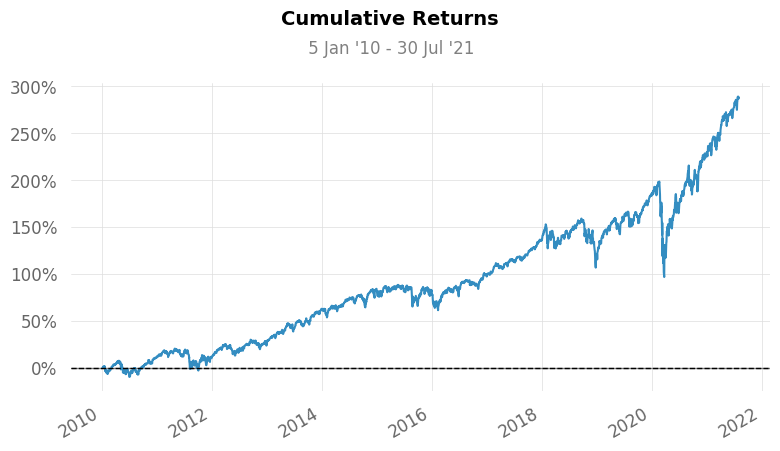

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


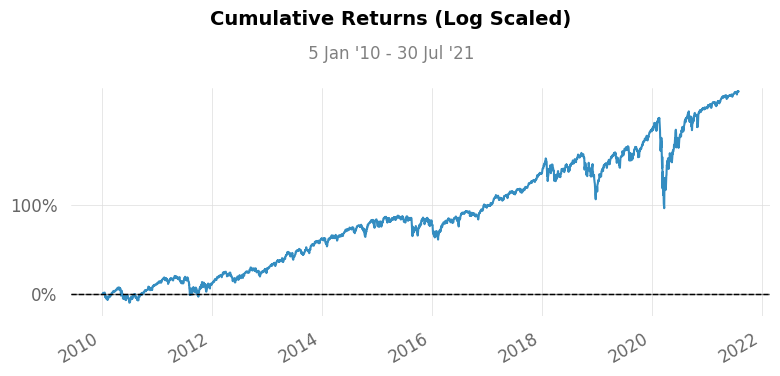

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


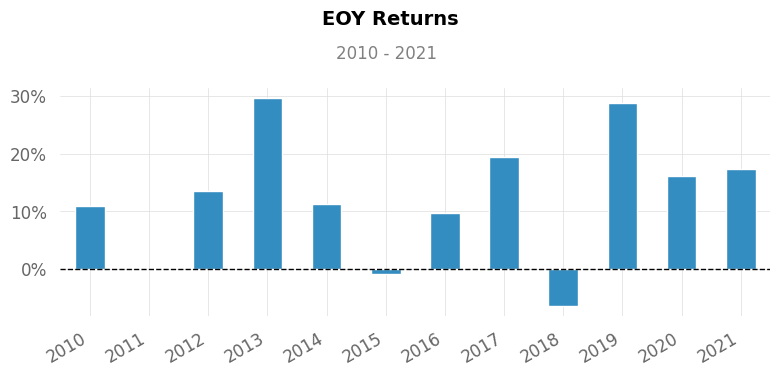

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


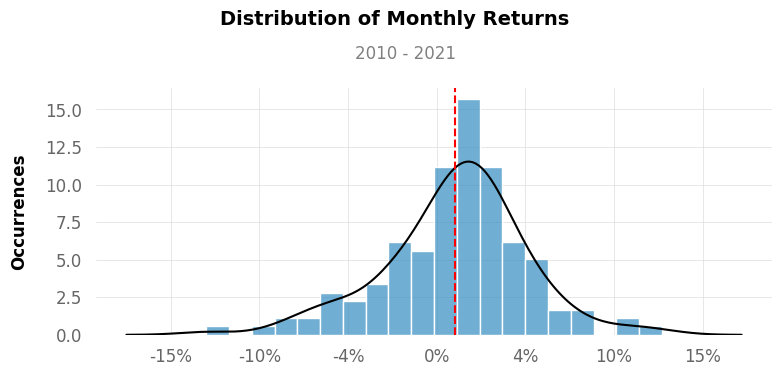

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


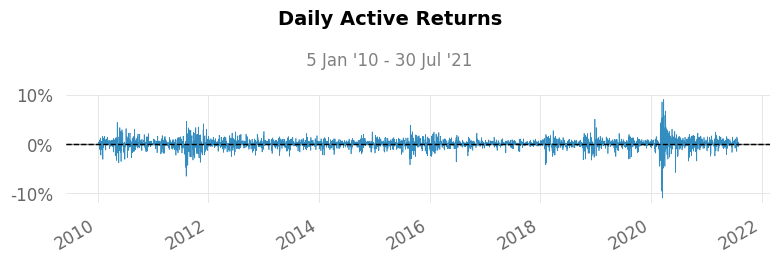

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


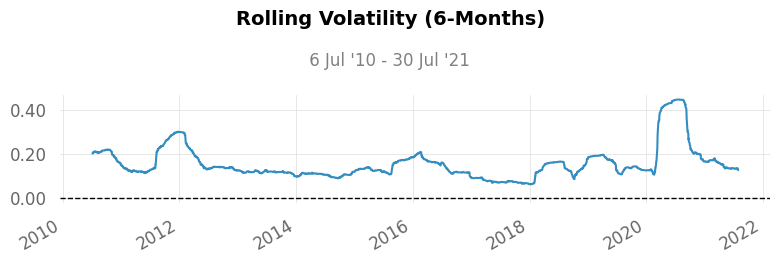

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


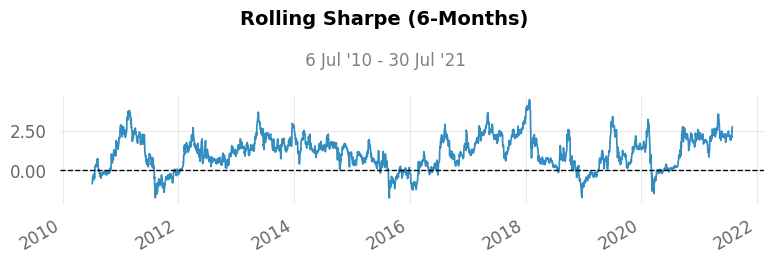

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


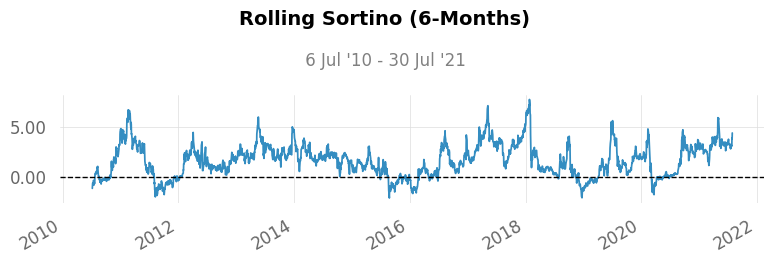

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


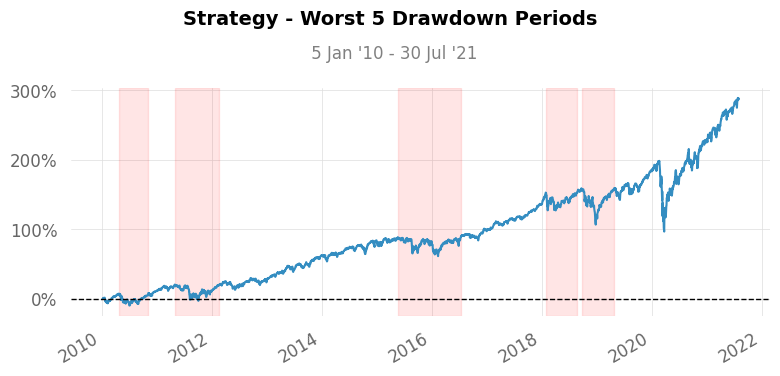

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


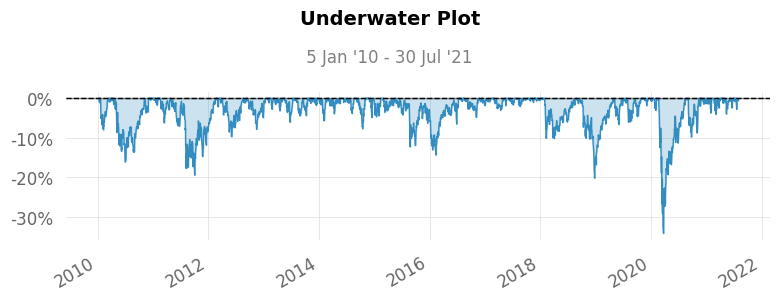

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


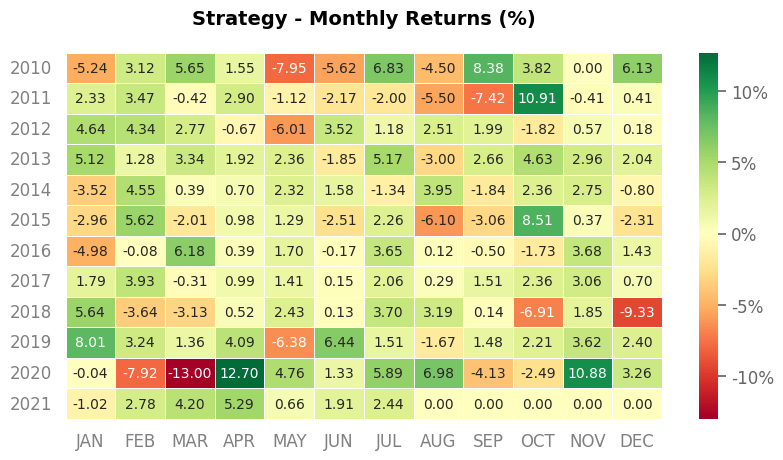

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


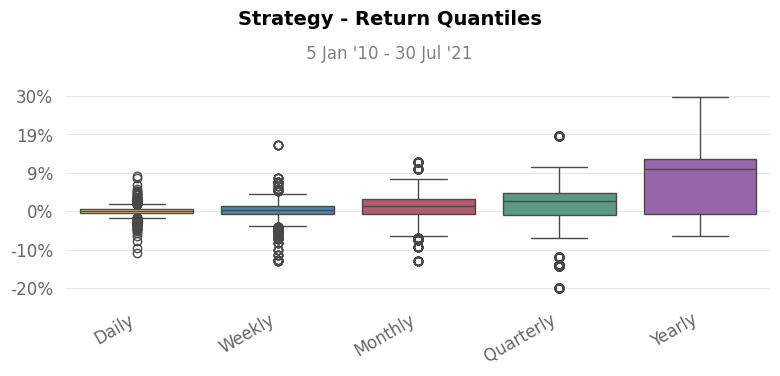

In [23]:
qs.reports.full(spy_return_series)

/home/yakub/.local/lib/python3.10/site-packages/pyfolio/plotting.py:666: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-38.232%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2019-01-02
End date,2019-12-31
Total months,12
,Backtest
Annual return,-38.232%
Cumulative returns,-38.232%
Annual volatility,39.178%
Sharpe ratio,-1.03
Calmar ratio,-0.83
Stability,0.66
Max drawdown,-45.798%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,45.80,2019-01-29,2019-11-19,NaT,NaN
1,8.17,2019-01-14,2019-01-17,2019-01-22,7
2,4.35,2019-01-02,2019-01-10,2019-01-14,9
3,4.12,2019-01-23,2019-01-25,2019-01-29,5
4,NaN,NaT,NaT,NaT,NaN


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2019-12-31 00:00:00+0000', tz='UTC'))

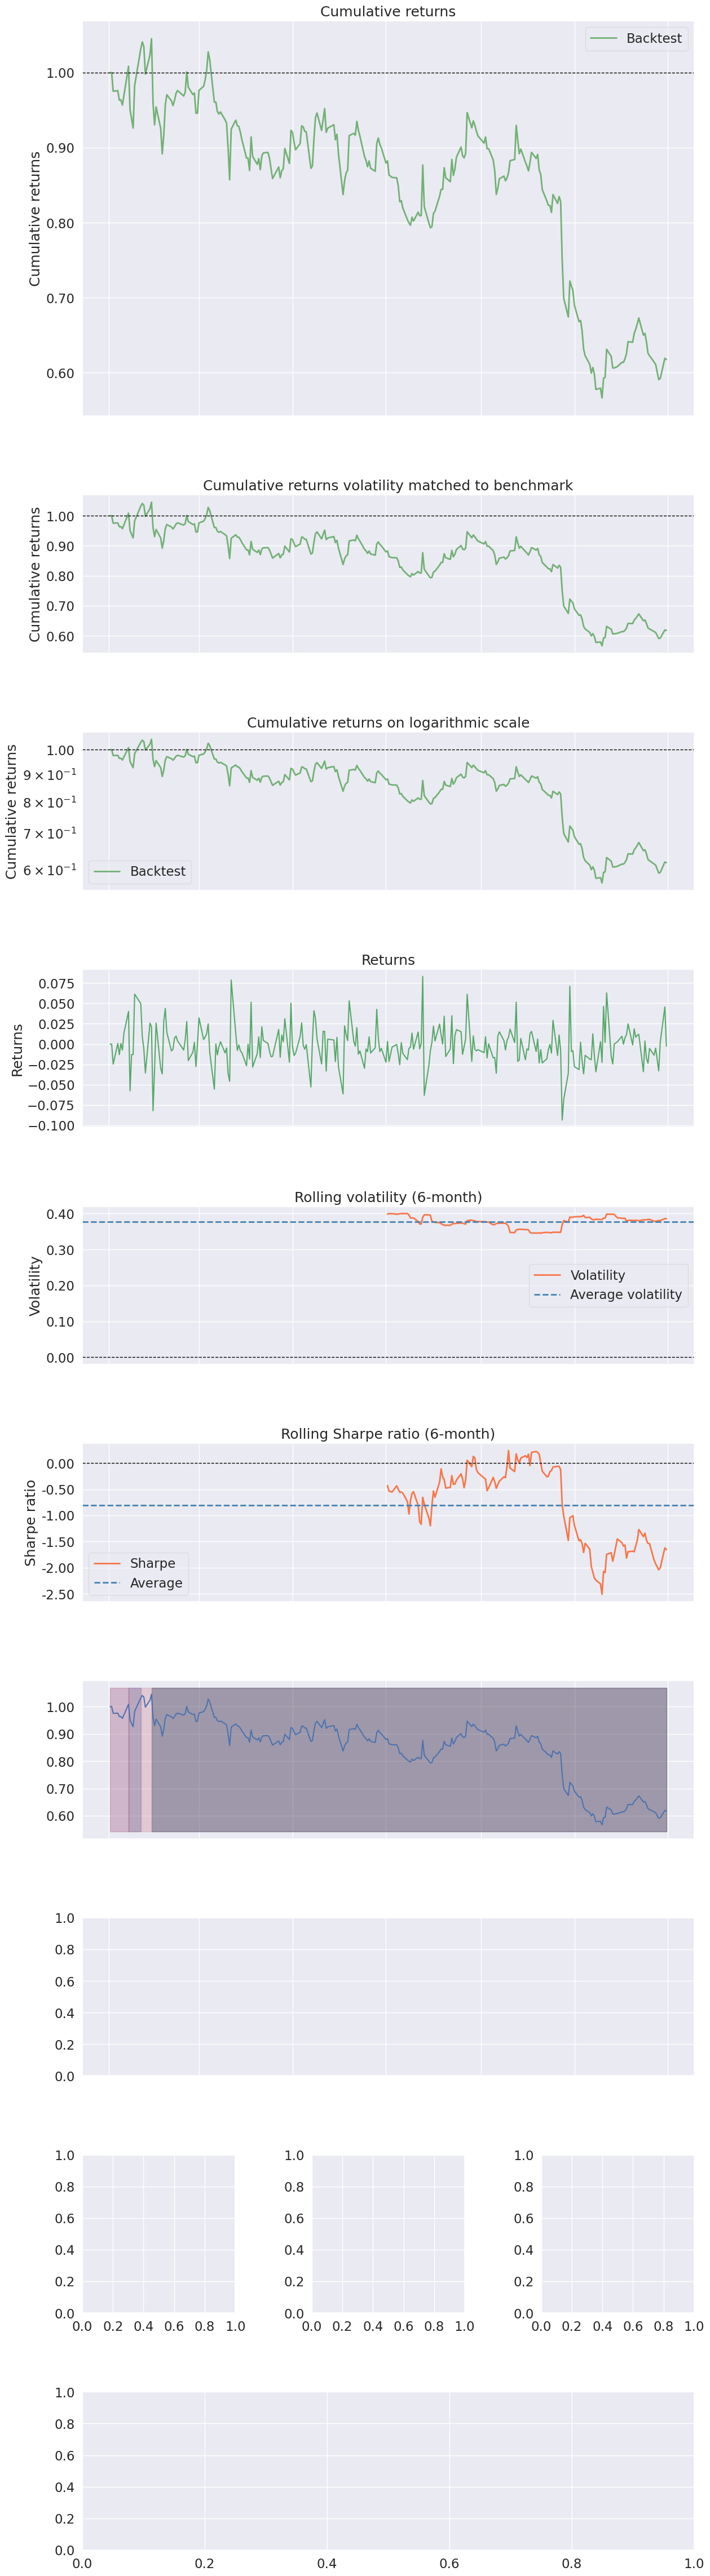

In [ ]:
# returns, positions, transactions = extract_rets_pos_txn_from_zipline(result)
# create_full_tear_sheet(returns, positions=positions, transactions=transactions)

### different way with SIDS

In [ ]:
bundle = 'sp5'
bundle_data = bundles.load(bundle)

In [ ]:
sids = bundle_data.asset_finder.sids
len(sids)

501

In [ ]:
ast = bundle_data.asset_finder.retrieve_all(sids)
ast[:5]

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV])]

In [ ]:
# calendar = get_calendar('XNYS')
# capital_base = 10000

# def initialize(context):
#     context.i = 0
#     sids = bundle_data.asset_finder.sids
#     ast = bundle_data.asset_finder.retrieve_all(sids)
#     context.assets = ast[:5]   # 5 assets from the bundle
    
# def handle_data(context, data):
#     context.i += 1
#     if context.i < 1: return
#     for asset in context.assets:
#         buy_signal = False
#         sell_signal  =False
#         price_hist = data.history(asset,'price', bar_count=26, frequency='1d')
        
#         ema_26 = ema(26,price_hist)
#         ema_12 = ema(12,price_hist)
#         MACD = [ema_26[j]-ema_12[j] for j in range(len(price_hist))]
#         signal = ema(9,MACD)
        
#         open_orders = get_open_orders()
#         if asset not in open_orders:
#             if MACD[-1]>signal[-1] and MACD[-2] < signal[-2]:    # Bullish crossover
#                 order(asset,1)
#                 buy_signal = True
#             elif MACD[-1]<signal[-1] and MACD[-2] > signal[-2]:    # Bearish crossover
#                 order(asset,0)
#                 sell_signal = True
        
#         record( amz_close = data.current(asset, "close"),
#                 MACD = MACD[-1],
#                 signal =signal[-1],
#                 sell_signal = sell_signal,
#                 buy_signal = buy_signal,
#                 price_hist = price_hist
#                 )

In [ ]:
# %%capture

# start_date = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
# end_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d')

# result2 = run_algorithm(
#     start = start_date,
#     end = end_date,
#     initialize=initialize,
#     handle_data = handle_data,
#     trading_calendar=calendar,
#     bundle='sp5',
#     capital_base=capital_base,
#     data_frequency='daily'
# )

# RSI as Mean Reversion Indicator

In [ ]:
def RSI(df, window, matype=1):
    rsi_period = window

    df['gain'] = (df['close'] - df['open']).apply(lambda x: x if x > 0 else 0)
    df['loss'] = (df['close'] - df['open']).apply(lambda x: -x if x < 0 else 0)

    if matype==2:
        df['ema_gain'] = df['gain'].ewm(span=rsi_period, min_periods=rsi_period).mean()
        df['ema_loss'] = df['loss'].ewm(span=rsi_period, min_periods=rsi_period).mean()
    if matype==1:
        df['ema_gain'] = df['gain'].rolling(rsi_period).mean()
        df['ema_loss'] = df['loss'].rolling(rsi_period).mean()

    df['rs'] = df['ema_gain'] / df['ema_loss']
    df['rsi_14'] = 100 - (100 / (df['rs'] + 1))
    return df

In [ ]:
bundle = 'sp5'
bundle_data = bundles.load(bundle)

In [ ]:
%%capture
start = '2020-01-01'
end = '2021-01-01'
capital_base = 10000
calendar = get_calendar('XNYS')
window = 30

def initialize(context):
    context.i = 0
    # context.assets = [symbol("AMZN"), symbol("AAPL"), symbol("GOOGL"),symbol("TSLA"),symbol("MSFT")]
    sids = bundle_data.asset_finder.sids
    ast = bundle_data.asset_finder.retrieve_all(sids)
    context.assets = ast[:5]   # 5 assets from the bundle

def handle_data(context, data):
    context.i += 1
    if context.i < window+1:
        return
    for asset in context.assets:
        prices = data.history(asset, ['open','close','price'], bar_count=30, frequency='1d')
        rsi_value = RSI(prices, 14).rsi_14[-1]
        
        if data.can_trade(asset) and not get_open_orders(asset):
            cash = context.portfolio.cash
            price = data.current(asset, "price")
            #open_orders = get_open_orders()
            if rsi_value > 70:
                order_target_percent(asset, -10, stop_price=(price * 0.90))
            elif rsi_value < 30:
                order_target_percent(asset, 10, stop_price=(price * 0.90))
            else:
                order_target(asset, 0)

        record(closing_price=data.current(asset, 'close'),
            rsi=rsi_value)

#............................................................................................
start_date = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d')

result_rsi = run_algorithm(
    start = start_date,
    end = end_date,
    initialize=initialize,
    handle_data = handle_data,
    trading_calendar=calendar,
    bundle='sp5',
    capital_base=capital_base,
    data_frequency='daily'
)

In [ ]:
result_rsi.tail(5)

,period_open,period_close,ending_exposure,starting_value,returns,ending_value,starting_cash,ending_cash,portfolio_value,longs_count,...,max_leverage,excess_return,treasury_period_return,trading_days,period_label,algo_volatility,benchmark_period_return,benchmark_volatility,closing_price,rsi
2019-12-24 18:00:00+00:00,2019-12-24 14:31:00+00:00,2019-12-24 18:00:00+00:00,-49717.14,-49916.90,-0.004818,-49717.14,8459.936815,8459.936815,-41257.203185,1,...,295.555553,0.0,0.0,248,2019-12,10.255176,0.0,0.0,89.85,38.391960
2019-12-26 21:00:00+00:00,2019-12-26 14:31:00+00:00,2019-12-26 21:00:00+00:00,-50787.44,-49717.14,0.025942,-50787.44,8459.936815,8459.936815,-42327.503185,1,...,295.555553,0.0,0.0,249,2019-12,10.234623,0.0,0.0,89.83,39.019408
2019-12-27 21:00:00+00:00,2019-12-27 14:31:00+00:00,2019-12-27 21:00:00+00:00,-48205.52,-50787.44,-0.060999,-48205.52,8459.936815,8459.936815,-39745.583185,1,...,295.555553,0.0,0.0,250,2019-12,10.214105,0.0,0.0,89.20,36.943907
2019-12-30 21:00:00+00:00,2019-12-30 14:31:00+00:00,2019-12-30 21:00:00+00:00,-48005.32,-48205.52,-0.005037,-48005.32,8459.936815,8459.936815,-39545.383185,1,...,295.555553,0.0,0.0,251,2019-12,10.193683,0.0,0.0,88.52,37.231969
2019-12-31 21:00:00+00:00,2019-12-31 14:31:00+00:00,2019-12-31 21:00:00+00:00,-48829.88,-48005.32,0.020851,-48829.88,8459.936815,8459.936815,-40369.943185,1,...,295.555553,0.0,0.0,252,2019-12,10.173473,0.0,0.0,88.54,40.566960


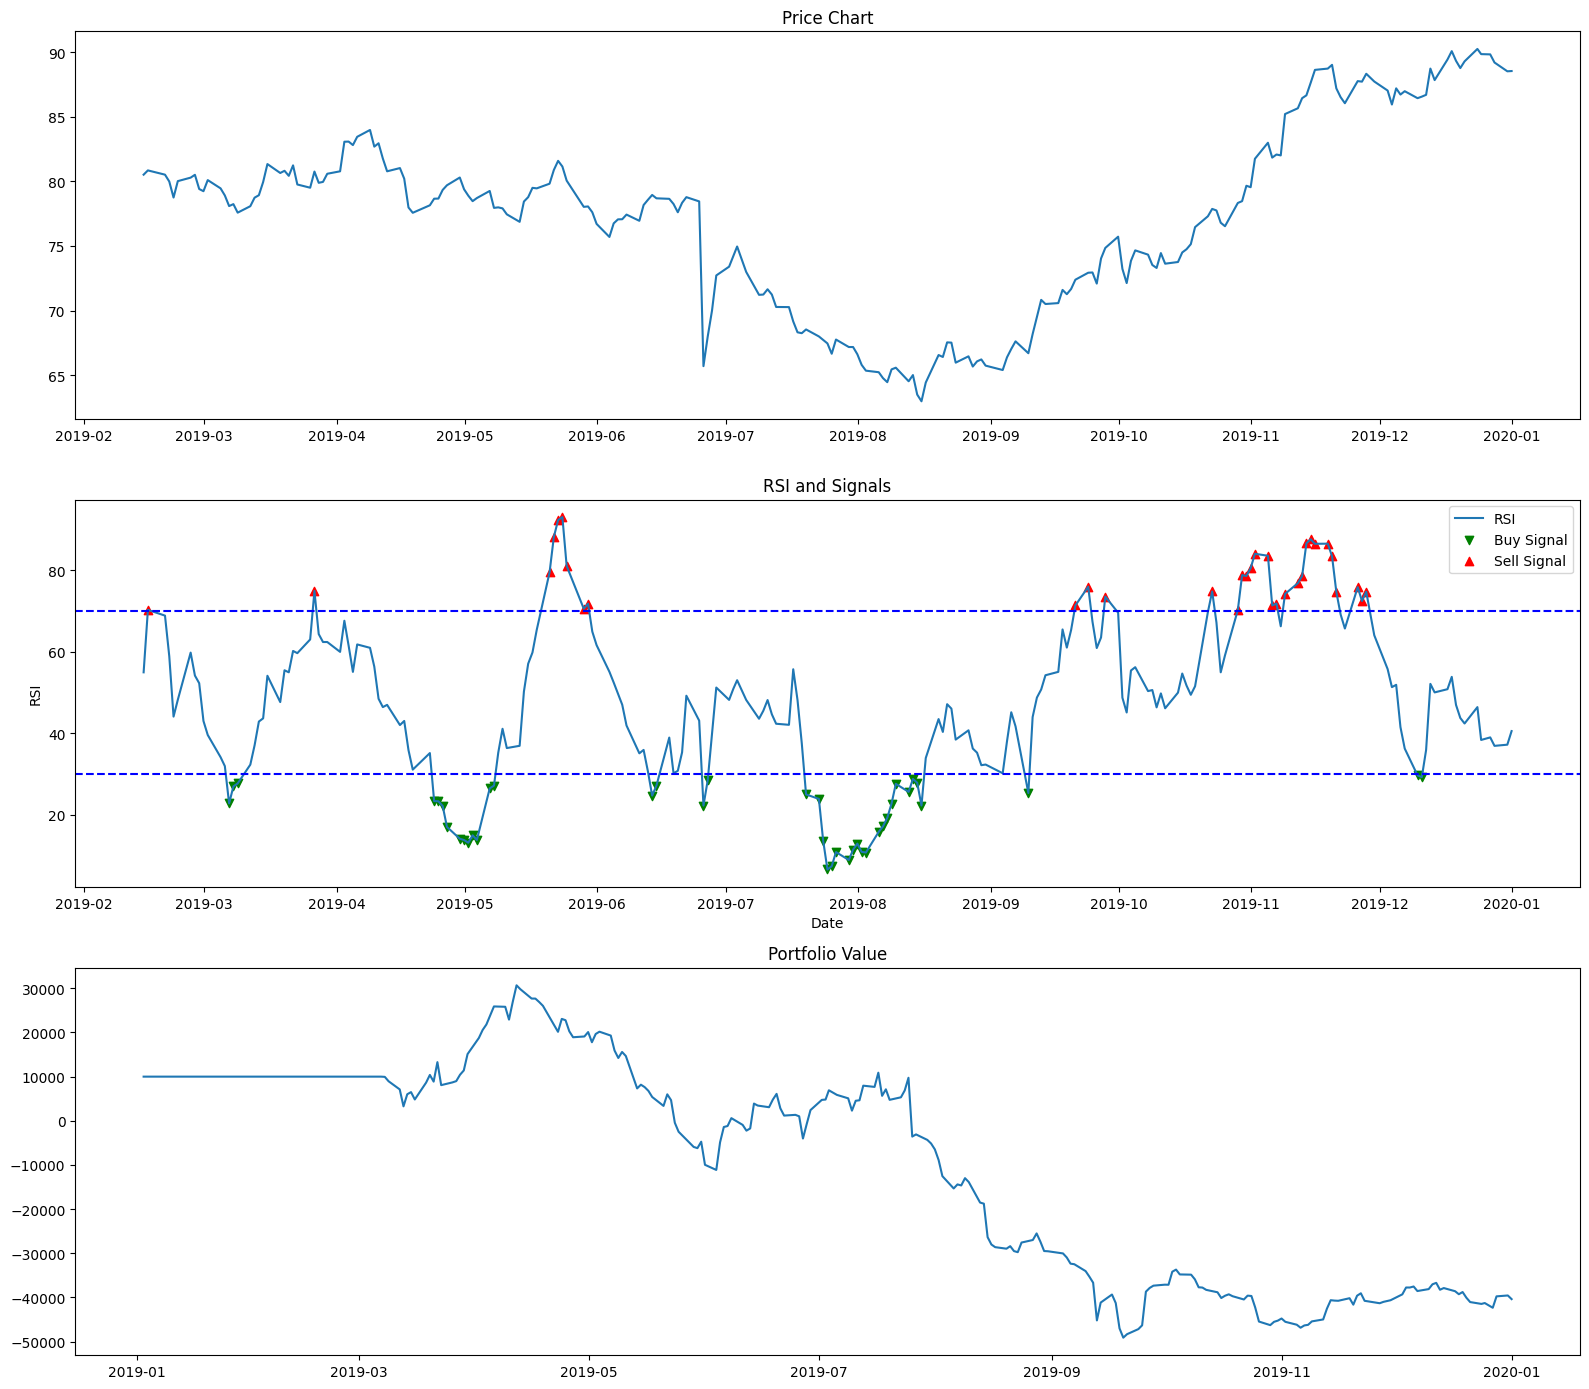

Buycount:41, Sellcount:33


In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2,ax3) = plt.subplots(3,figsize=(16,14))

ax1.plot(result_rsi.index, result_rsi['closing_price'])
ax1.set_title('Price Chart')

ax2.plot(result_rsi.index, result_rsi['rsi'], label='RSI')

buy_signals = result_rsi[result_rsi['rsi'] < 30]
sell_signals = result_rsi[result_rsi['rsi'] > 70]

ax2.scatter(buy_signals.index, buy_signals['rsi'],marker='v', color='green', label='Buy Signal')
ax2.scatter(sell_signals.index, sell_signals['rsi'],marker='^', color='red', label='Sell Signal')

ax2.set_title('RSI and Signals')
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.axhline(y=30, color='blue', linestyle='--')
ax2.axhline(y=70, color='blue', linestyle='--')
ax2.legend(loc=0)

ax3.plot(result_rsi.index, result_rsi['portfolio_value'])
ax3.set_title('Portfolio Value')
plt.tight_layout()
plt.show()

print(f'Buycount:{len(buy_signals.index)}, Sellcount:{len(sell_signals.index)}')

# Performance plot
# (1 + result_rsi['portfolio_value'].pct_change()).cumprod().plot(ax=ax3)
# (1 + result_rsi['closing_price'].pct_change()).cumprod().plot(ax=ax3)
# ax3.set_ylabel('Performance')
# ax3.legend(['Portfolio', 'Asset'])

# plt.tight_layout()
# plt.show()

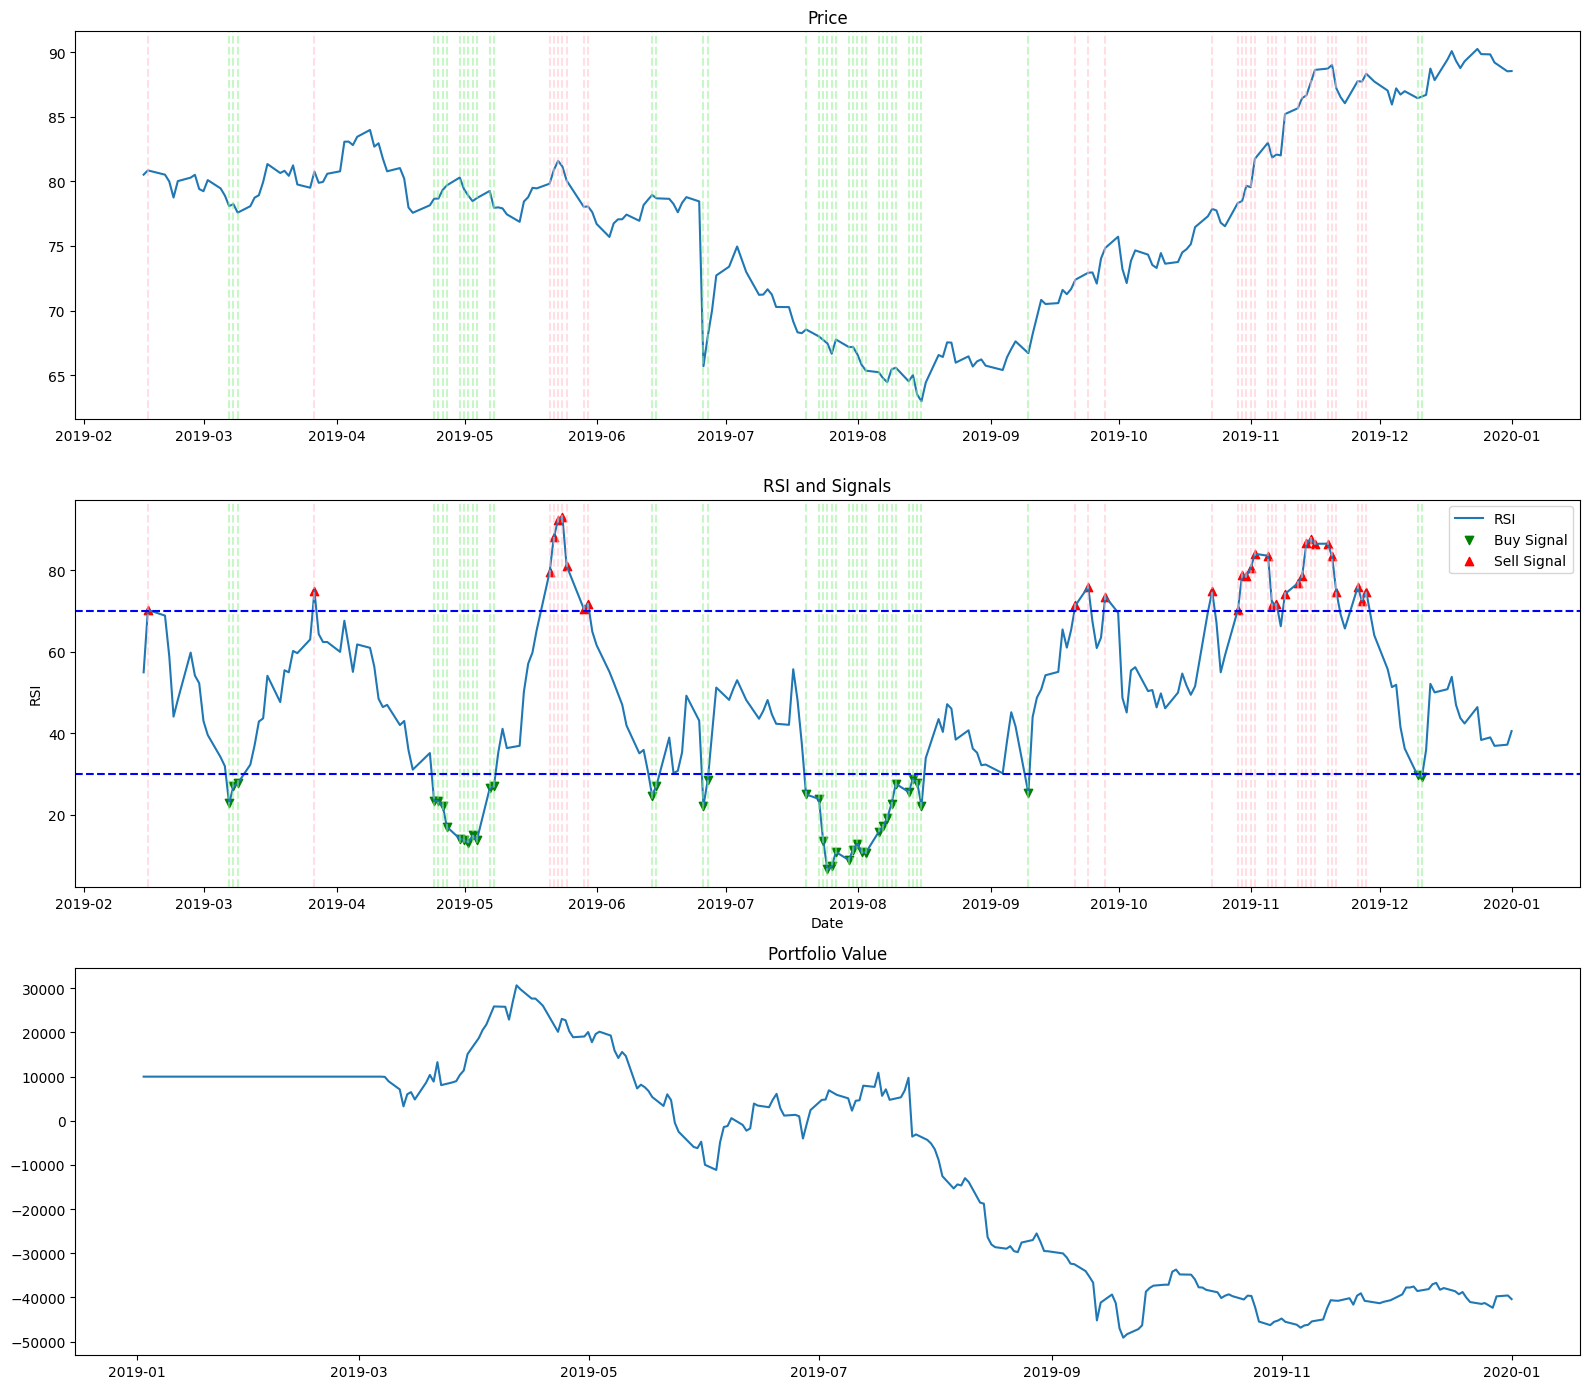

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(16,14))

ax1.plot(result_rsi.index, result_rsi['closing_price'])
ax1.set_title('Price')

ax2.plot(result_rsi.index, result_rsi['rsi'], label='RSI')

buy_signals = result_rsi[result_rsi['rsi'] < 30]
sell_signals = result_rsi[result_rsi['rsi'] > 70]

ax2.scatter(buy_signals.index, buy_signals['rsi'],marker='v', color='green', label='Buy Signal')
ax2.scatter(sell_signals.index, sell_signals['rsi'],marker='^', color='red', label='Sell Signal')

for buy_date in buy_signals.index:
    ax1.axvline(x=buy_date, color='lightgreen', linestyle='--', alpha=0.5)
    ax2.axvline(x=buy_date, color='lightgreen', linestyle='--', alpha=0.5)

for sell_date in sell_signals.index:
    ax1.axvline(x=sell_date, color='pink', linestyle='--', alpha=0.5)
    ax2.axvline(x=sell_date, color='pink', linestyle='--', alpha=0.5)

ax2.set_title('RSI and Signals')
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.axhline(y=30, color='blue', linestyle='--')
ax2.axhline(y=70, color='blue', linestyle='--')
ax2.legend(loc=0)

ax3.plot(result_rsi.index, result_rsi['portfolio_value'])
ax3.set_title('Portfolio Value')
plt.tight_layout()
plt.show()

# Bollinger Bands

In [ ]:
%%capture
capital_base = 10000
calendar = get_calendar('XNYS')
window = 180

def initialize(context):
    context.i = 0
    # set_benchmark(symbol(symb))
    sids = bundle_data.asset_finder.sids
    ast = bundle_data.asset_finder.retrieve_all(sids)
    context.assets = ast[:5]
    

def handle_data(context, data):
    # Skip first 90 days to get full windows
    context.i += 1
    if context.i < window+1:
        return

    current_date = data.history(context.assets[0], 'price', bar_count=2, frequency="1d").index[-1]
    for asset in context.assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            current_price = data.current(asset, "price")
            prices = data.history(asset, 'close', 31, frequency='1d')
            sma = prices.mean()
            rolling_std = prices.std()
            upper_band = sma + (2 * rolling_std)
            lower_band = sma - (2 * rolling_std)

            if current_price > upper_band:
                order_target(asset, 0)      # selliing
            elif current_price < lower_band:
                order_target(asset, 100)   
            else:
                pass
            record(
            ASSET_price=data.current(asset, "price"),
            upper_band=upper_band,
            lower_band=lower_band
        )


    
start_date = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d')

result_bb = run_algorithm(
    start = start_date,
    end = end_date,
    initialize=initialize,
    handle_data = handle_data,
    trading_calendar=calendar,
    bundle='sp5',
    capital_base=capital_base,
    data_frequency='daily'
)

Buy signals: 0
Sell signals: 11


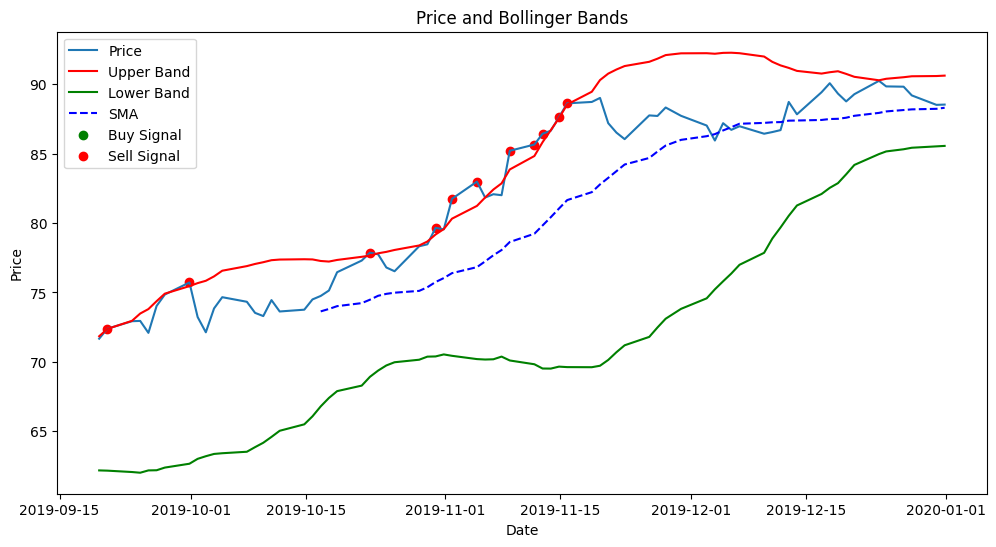

In [ ]:
result_bb['sma'] = result_bb['ASSET_price'].rolling(window=20).mean()

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(result_bb.index, result_bb['ASSET_price'], label='Price')
ax.plot(result_bb.index, result_bb['upper_band'], label='Upper Band', color='red')
ax.plot(result_bb.index, result_bb['lower_band'], label='Lower Band', color='green')

ax.plot(result_bb.index, result_bb['sma'], label='SMA', color='blue',linestyle='--')

buy_signals = result_bb[result_bb['ASSET_price'] < result_bb['lower_band']]
sell_signals = result_bb[result_bb['ASSET_price'] > result_bb['upper_band']]
ax.scatter(buy_signals.index, buy_signals['ASSET_price'], color='green', label='Buy Signal')
ax.scatter(sell_signals.index, sell_signals['ASSET_price'], color='red', label='Sell Signal')

print(f'Buy signals: {len(buy_signals)}')
print(f'Sell signals: {len(sell_signals)}')

ax.set_title('Price and Bollinger Bands')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
plt.show()
